# 경구약제 이미지 데이터 EDA

## 1. EDA 개요

제공된 Ai Hub 경구약제 이미지 데이터셋은 PNG 이미지와 COCO 포맷의 JSON 주석 파일로 구성되어 있습니다. 본 EDA에서는 다음 항목들을 분석하여 데이터의 전반적인 특성을 파악하고 모델링 전략을 수립하는 데 필요한 인사이트를 얻을 것입니다.

- 데이터셋 구조 및 규모 확인
- JSON 어노테이션 파일 구조 및 핵심 필드 이해
- 클래스(알약 종류) 정보 및 분포 분석
- 이미지 특성 (크기, 채널 등) 분석
- 어노테이션 특성 (알약 개수, 바운딩 박스 크기 및 종횡비) 분석
- 촬영 환경 메타데이터 분석
- 데이터 시각화를 통한 직관적 이해

## 2. 환경 설정 및 라이브러리 임포트

필요한 라이브러리들을 임포트하고 데이터셋 경로를 설정합니다.

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import random

# 경고 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
except Exception as e:
    print(f"경고: 한글 폰트 설정 중 오류 발생 ({e}). NanumGothic 폰트가 설치되어 있는지 확인해주세요.")

print("환경 설정 및 라이브러리 임포트 완료")

환경 설정 및 라이브러리 임포트 완료


In [2]:
# 데이터셋 경로 설정
DATA_ROOT = '../data/raw' # 사용자 환경에 맞게 조정
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

print(f"TRAIN_IMG_DIR: {TRAIN_IMG_DIR}")
print(f"TRAIN_ANNO_DIR: {TRAIN_ANNO_DIR}")
print(f"TEST_IMG_DIR: {TEST_IMG_DIR}")

# 디렉토리 존재 여부 확인 및 입력 유도
if not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(TRAIN_ANNO_DIR) or not os.path.exists(TEST_IMG_DIR):
    print("현재 설정된 경로 중 하나 이상을 찾을 수 없습니다.")
    
    suggested_root = input("올바른 DATA_ROOT 경로를 입력하세요: ")
    if os.path.exists(os.path.join(suggested_root, 'train_images')):
        DATA_ROOT = suggested_root
        TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
        TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations')
        TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')
        print(f"경로가 '{DATA_ROOT}'(으)로 업데이트 되었습니다. 계속 진행합니다.")
    else:
        print("입력된 경로도 유효하지 않아 프로그램을 종료합니다. 경로를 다시 확인해주세요.")
        exit() # 경로 문제로 EDA 진행 불가 시 종료

TRAIN_IMG_DIR: ../data/raw/train_images
TRAIN_ANNO_DIR: ../data/raw/train_annotations
TEST_IMG_DIR: ../data/raw/test_images


## 3. 데이터셋 구조 및 규모 확인

주어진 파일 구조에 맞춰 train_annotations 내부의 .json 파일을 재귀적으로 탐색합니다.

In [3]:
# --- JSON 파일을 재귀적으로 탐색하는 헬퍼 함수 ---
def find_json_files_recursively(root_dir):
    json_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.json'):
                json_files.append(os.path.join(dirpath, filename))
    return json_files

# 파일 개수 세기
train_image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.png')]
train_annotation_full_paths = find_json_files_recursively(TRAIN_ANNO_DIR)
test_image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.png')]

print(f"총 훈련 이미지 개수: {len(train_image_files)}")
print(f"총 훈련 어노테이션 파일 개수: {len(train_annotation_full_paths)}")
print(f"총 테스트 이미지 개수: {len(test_image_files)}")

if len(train_image_files) > 0 and len(train_annotation_full_paths) > 0:
    print("\n훈련 이미지와 어노테이션 파일이 모두 존재하는 것을 확인했습니다. 파싱 단계에서 정확한 매칭을 수행합니다.")
else:
    print("\n훈련 이미지 또는 어노테이션 파일이 충분하지 않아 보입니다. 확인이 필요합니다.")

총 훈련 이미지 개수: 651
총 훈련 어노테이션 파일 개수: 1001
총 테스트 이미지 개수: 843

훈련 이미지와 어노테이션 파일이 모두 존재하는 것을 확인했습니다. 파싱 단계에서 정확한 매칭을 수행합니다.


## 4. JSON 어노테이션 파일 분석

제공된 JSON 형식에 맞춰 images 섹션과 annotations 섹션에서 필요한 정보를 추출하고 Pandas DataFrame으로 통합합니다. images 섹션의 중복 처리 기준을 file_name으로 하여 정확한 이미지 메타데이터를 추출하고, 최종적으로 유효한 데이터만 필터링합니다.

In [4]:
all_images_meta = [] # 각 이미지의 메타데이터 (약 종류, 모양, 색상 등)
all_annotations = [] # 각 바운딩 박스 정보
all_category_mappings = [] # 모든 JSON 파일에서 발견된 category-id-name 매핑

print("훈련 어노테이션 파일 파싱 중...")
# 중복 image_file_name, annotation_id, category_id-name 쌍 처리를 위한 집합
parsed_image_filenames_set = set() # images['file_name'] 기준으로 중복 제거
parsed_annotation_ids_set = set()
parsed_category_id_name_pairs_set = set()

for full_path in tqdm(train_annotation_full_paths, desc="Parsing Annotations"):
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"경고: {full_path} 파일 파싱 중 오류 발생: {e}. 건너뜁니다.")
        continue
    except Exception as e:
        print(f"경고: {full_path} 파일 로드 중 예외 발생: {e}. 건너뜁니다.")
        continue

    # 'images' 섹션 처리
    if 'images' in data:
        for img_info in data['images']:
            if img_info['file_name'] not in parsed_image_filenames_set:
                img_info['source_json_file'] = full_path # 어떤 JSON 파일에서 왔는지 기록
                all_images_meta.append(img_info)
                parsed_image_filenames_set.add(img_info['file_name'])
    
    # 'annotations' 섹션 처리
    if 'annotations' in data:
        for anno_info in data['annotations']:
            # 'bbox' 유효성 검증 및 annotation ID 중복 방지
            if ('bbox' in anno_info and anno_info['bbox'] and len(anno_info['bbox']) == 4 and
                anno_info['id'] not in parsed_annotation_ids_set):
                anno_info['source_json_file'] = full_path
                all_annotations.append(anno_info)
                parsed_annotation_ids_set.add(anno_info['id'])

    # 'categories' 섹션 처리
    if 'categories' in data:
        for cat_info in data['categories']:
            # (id, name) 쌍으로 고유성 관리하여 중복 추가 방지
            cat_id_name_pair = (cat_info['id'], cat_info['name'])
            if cat_id_name_pair not in parsed_category_id_name_pairs_set:
                all_category_mappings.append(cat_info)
                parsed_category_id_name_pairs_set.add(cat_id_name_pair)

# DataFrame 생성
images_df = pd.DataFrame(all_images_meta)
annotations_df = pd.DataFrame(all_annotations)
categories_df = pd.DataFrame(all_category_mappings)

print("\n파싱 완료")
print(f"이미지 메타데이터 (images_df) 개수: {len(images_df)}")
print(f"어노테이션 (annotations_df) 개수: {len(annotations_df)}")
print(f"총 고유 카테고리 (categories_df) 개수: {len(categories_df)}")

# 어노테이션에 이미지 메타데이터 정보 병합
# `annotations_df`의 `image_id`와 `images_df`의 `id`를 기준으로 병합
annotations_df = pd.merge(annotations_df, 
                          images_df[['id', 'file_name', 'dl_name', 'drug_shape', 'color_class1', 
                                     'back_color', 'light_color', 'print_front', 'dl_idx']], 
                          left_on='image_id', right_on='id', how='left', suffixes=('_anno', '_img'))

# 중복된 'id_img' 컬럼은 제거 (annotations_df에 'image_id'가 이미 있으므로)
annotations_df.drop(columns=['id_img'], inplace=True)

# 최종 글로벌 카테고리 매핑 테이블 생성 (categories_df의 id와 name 사용)
global_categories_df = categories_df[['id', 'name']].copy()
global_categories_df.rename(columns={'id': 'global_category_id', 'name': 'global_class_name'}, inplace=True)

print(f"\n최종 통합된 고유 알약 클래스 개수 (global_categories_df): {len(global_categories_df)}개")

# 어노테이션 DataFrame에 최종 global_class_name 추가 (category_id는 이미 글로벌 ID와 동일함)
annotations_df = pd.merge(annotations_df, global_categories_df[['global_category_id', 'global_class_name']], 
                          left_on='category_id', right_on='global_category_id', how='left')
annotations_df.drop(columns=['global_category_id'], inplace=True) # 중복 컬럼 제거 (annotations_df에는 category_id가 이미 있음)

# 이미지 폴더와 JSON 어노테이션 간의 불일치 여부 확인 및 필터링
all_train_image_filenames = set([os.path.basename(f) for f in train_image_files])
parsed_image_filenames_from_json = set(images_df['file_name'].tolist())

# 유효한 이미지 파일명: 폴더에도 있고, JSON에도 언급된 파일명만
valid_image_filenames = all_train_image_filenames.intersection(parsed_image_filenames_from_json)

unmatched_images_in_folder = all_train_image_filenames - valid_image_filenames
unmatched_images_in_json = parsed_image_filenames_from_json - valid_image_filenames

if len(unmatched_images_in_folder) > 0:
    print(f"\n경고: {len(unmatched_images_in_folder)}개의 이미지 파일은 폴더에 있지만, JSON 어노테이션에 언급되지 않았습니다.")
    print(f"일부 불일치 이미지 파일: {list(unmatched_images_in_folder)[:5]}")
if len(unmatched_images_in_json) > 0:
    print(f"\n경고: {len(unmatched_images_in_json)}개의 이미지 파일은 JSON 어노테이션에는 언급되었지만, 실제 폴더에는 존재하지 않습니다.")
    print(f"일부 불일치 이미지 파일: {list(unmatched_images_in_json)[:5]}")

if len(unmatched_images_in_folder) == 0 and len(unmatched_images_in_json) == 0:
    print("\n모든 이미지 파일이 JSON 어노테이션에 정확히 매칭됩니다.")
else:
    print("\n이미지 파일과 JSON 어노테이션 간의 불일치가 있습니다. 학습 데이터 필터링을 진행합니다.")

# images_df와 annotations_df를 유효한 파일명 기준으로 필터링
images_df = images_df[images_df['file_name'].isin(valid_image_filenames)].reset_index(drop=True)

# annotations_df는 image_id를 images_df에서 가져오므로, images_df 필터링 후 다시 병합하는 것이 안전
annotations_df = annotations_df[annotations_df['file_name'].isin(valid_image_filenames)].reset_index(drop=True)

print(f"\n최종 필터링 후 학습에 사용 가능한 이미지 개수 (images_df): {len(images_df)}개")
print(f"최종 필터링 후 학습에 사용 가능한 어노테이션 개수 (annotations_df): {len(annotations_df)}개")


훈련 어노테이션 파일 파싱 중...


Parsing Annotations:   0%|          | 0/1001 [00:00<?, ?it/s]


파싱 완료
이미지 메타데이터 (images_df) 개수: 369
어노테이션 (annotations_df) 개수: 1001
총 고유 카테고리 (categories_df) 개수: 56

최종 통합된 고유 알약 클래스 개수 (global_categories_df): 56개

경고: 419개의 이미지 파일은 폴더에 있지만, JSON 어노테이션에 언급되지 않았습니다.
일부 불일치 이미지 파일: ['K-003483-025367-027653-035206_0_2_0_2_90_000_200.png', 'K-001900-016551-019607-031705_0_2_0_2_75_000_200.png', 'K-003483-016262-027653-030308_0_2_0_2_75_000_200.png', 'K-003483-020238-025469-031885_0_2_0_2_75_000_200.png', 'K-003483-016262-020877-028763_0_2_0_2_75_000_200.png']

경고: 137개의 이미지 파일은 JSON 어노테이션에는 언급되었지만, 실제 폴더에는 존재하지 않습니다.
일부 불일치 이미지 파일: ['K-003351-020014-029667_0_2_0_2_70_000_200.png', 'K-003351-013900-035206_0_2_0_2_90_000_200.png', 'K-003351-013900-035206_0_2_0_2_75_000_200.png', 'K-003351-018147-021325_0_2_0_2_75_000_200.png', 'K-003351-031863-036637_0_2_0_2_70_000_200.png']

이미지 파일과 JSON 어노테이션 간의 불일치가 있습니다. 학습 데이터 필터링을 진행합니다.

최종 필터링 후 학습에 사용 가능한 이미지 개수 (images_df): 232개
최종 필터링 후 학습에 사용 가능한 어노테이션 개수 (annotations_df): 763개


In [5]:
print("통합된 어노테이션 데이터프레임 헤드:")
annotations_df.head()

통합된 어노테이션 데이터프레임 헤드:


,area,iscrowd,bbox,category_id,ignore,segmentation,id_anno,image_id,source_json_file,file_name,dl_name,drug_shape,color_class1,back_color,light_color,print_front,dl_idx,global_class_name
0,33672,0,"[403, 226, 184, 183]",3350,0,[],3098,816,../data/raw/train_annotations/K-003351-020238-...,K-003351-020238-032310_0_2_0_2_90_000_200.png,일양하이트린정 2mg,원형,주황,연회색 배경,주백색,I분할선Y,3350,일양하이트린정 2mg
1,37442,0,"[385, 859, 193, 194]",3350,0,[],3096,814,../data/raw/train_annotations/K-003351-020238-...,K-003351-020238-032310_0_2_0_2_70_000_200.png,일양하이트린정 2mg,원형,주황,연회색 배경,주백색,I분할선Y,3350,일양하이트린정 2mg
2,98612,0,"[560, 715, 277, 356]",32309,0,[],3092,816,../data/raw/train_annotations/K-003351-020238-...,K-003351-020238-032310_0_2_0_2_90_000_200.png,일양하이트린정 2mg,원형,주황,연회색 배경,주백색,I분할선Y,3350,글리아타민연질캡슐
3,87316,0,"[151, 231, 263, 332]",32309,0,[],3090,814,../data/raw/train_annotations/K-003351-020238-...,K-003351-020238-032310_0_2_0_2_70_000_200.png,일양하이트린정 2mg,원형,주황,연회색 배경,주백색,I분할선Y,3350,글리아타민연질캡슐
4,49950,0,"[144, 800, 225, 222]",20237,0,[],3095,816,../data/raw/train_annotations/K-003351-020238-...,K-003351-020238-032310_0_2_0_2_90_000_200.png,일양하이트린정 2mg,원형,주황,연회색 배경,주백색,I분할선Y,3350,플라빅스정 75mg


In [6]:
print("글로벌 카테고리 데이터프레임 헤드:")
global_categories_df.head()

글로벌 카테고리 데이터프레임 헤드:


,global_category_id,global_class_name
0,3350,일양하이트린정 2mg
1,32309,글리아타민연질캡슐
2,20237,플라빅스정 75mg
3,18356,종근당글리아티린연질캡슐(콜린알포세레이트)
4,16231,리피토정 20mg


In [7]:
print("\n이미지 메타데이터 데이터프레임 헤드 (JSON 파싱 후):")
images_df.head()


이미지 메타데이터 데이터프레임 헤드 (JSON 파싱 후):


,file_name,width,height,imgfile,drug_N,drug_S,back_color,drug_dir,light_color,camera_la,...,form_code_name,mark_code_front_anal,mark_code_back_anal,mark_code_front_img,mark_code_back_img,mark_code_front,mark_code_back,change_date,id,source_json_file
0,K-003351-020238-032310_0_2_0_2_90_000_200.png,976,1280,K-003351-020238-032310_0_2_0_2_90_000_200.png,K-003351,정상알약,연회색 배경,앞면,주백색,90,...,나정,,,,,,,20170328,816,../data/raw/train_annotations/K-003351-020238-...
1,K-003351-020238-032310_0_2_0_2_70_000_200.png,976,1280,K-003351-020238-032310_0_2_0_2_70_000_200.png,K-003351,정상알약,연회색 배경,앞면,주백색,70,...,나정,,,,,,,20170328,814,../data/raw/train_annotations/K-003351-020238-...
2,K-003351-018357-020238_0_2_0_2_75_000_200.png,976,1280,K-003351-018357-020238_0_2_0_2_75_000_200.png,K-003351,정상알약,연회색 배경,앞면,주백색,75,...,나정,,,,,,,20170328,1325,../data/raw/train_annotations/K-003351-018357-...
3,K-003351-018357-020238_0_2_0_2_70_000_200.png,976,1280,K-003351-018357-020238_0_2_0_2_70_000_200.png,K-003351,정상알약,연회색 배경,앞면,주백색,70,...,나정,,,,,,,20170328,1324,../data/raw/train_annotations/K-003351-018357-...
4,K-003351-016232-033880_0_2_0_2_75_000_200.png,976,1280,K-003351-016232-033880_0_2_0_2_75_000_200.png,K-003351,정상알약,연회색 배경,앞면,주백색,75,...,나정,,,,,,,20170328,14,../data/raw/train_annotations/K-003351-016232-...


## 5. 알약 클래스 분석

모델이 검출해야 할 알약 클래스의 종류와 분포를 심층 분석합니다.

### 5.1. 고유 알약 클래스 개수 확인

In [8]:
num_unique_classes = len(global_categories_df)
print(f"모델이 검출해야 할 최종 고유 알약 클래스 개수 (category_id 기준): {num_unique_classes}개")

print("\n테스트셋에 포함될 클래스 개수 (제공 정보): 40개")
if num_unique_classes > 40:
    print(f"훈련셋 고유 클래스 ({num_unique_classes}개)가 테스트셋 포함 클래스(40개)보다 많습니다. 이는 제공 정보와 불일치하거나, 훈련셋에만 존재하는 클래스가 있음을 의미합니다.")
    print(f"({num_unique_classes - 40}개의 클래스는 테스트셋에 등장하지 않을 수 있습니다.)")
elif num_unique_classes < 40:
    print(f"훈련셋 고유 클래스 ({num_unique_classes}개)가 테스트셋 포함 클래스(40개)보다 적습니다. 이는 모델이 학습 시 보지 못한 클래스를 테스트셋에서 만날 수 있음을 의미하며, 이 40개 중 일부 클래스는 훈련셋에 없습니다.")
else:
    print(f"훈련셋 고유 클래스 ({num_unique_classes}개)와 테스트셋 클래스(40개) 개수가 일치합니다.")

# 클래스명 목록 확인
print("\n최종 알약 클래스 목록 (일부):")
for idx, row in global_categories_df.head(10).iterrows():
    print(f"  ID {row['global_category_id']}: {row['global_class_name']}")

모델이 검출해야 할 최종 고유 알약 클래스 개수 (category_id 기준): 56개

테스트셋에 포함될 클래스 개수 (제공 정보): 40개
훈련셋 고유 클래스 (56개)가 테스트셋 포함 클래스(40개)보다 많습니다. 이는 제공 정보와 불일치하거나, 훈련셋에만 존재하는 클래스가 있음을 의미합니다.
(16개의 클래스는 테스트셋에 등장하지 않을 수 있습니다.)

최종 알약 클래스 목록 (일부):
  ID 3350: 일양하이트린정 2mg
  ID 32309: 글리아타민연질캡슐
  ID 20237: 플라빅스정 75mg
  ID 18356: 종근당글리아티린연질캡슐(콜린알포세레이트) 
  ID 16231: 리피토정 20mg
  ID 33879: 글리틴정(콜린알포세레이트)
  ID 22073: 리피로우정 20mg
  ID 18146: 리리카캡슐 150mg
  ID 25366: 자누메트정 50/850mg
  ID 3482: 기넥신에프정(은행엽엑스)(수출용)


### 5.2. 클래스별 어노테이션 분포 (클래스 불균형)

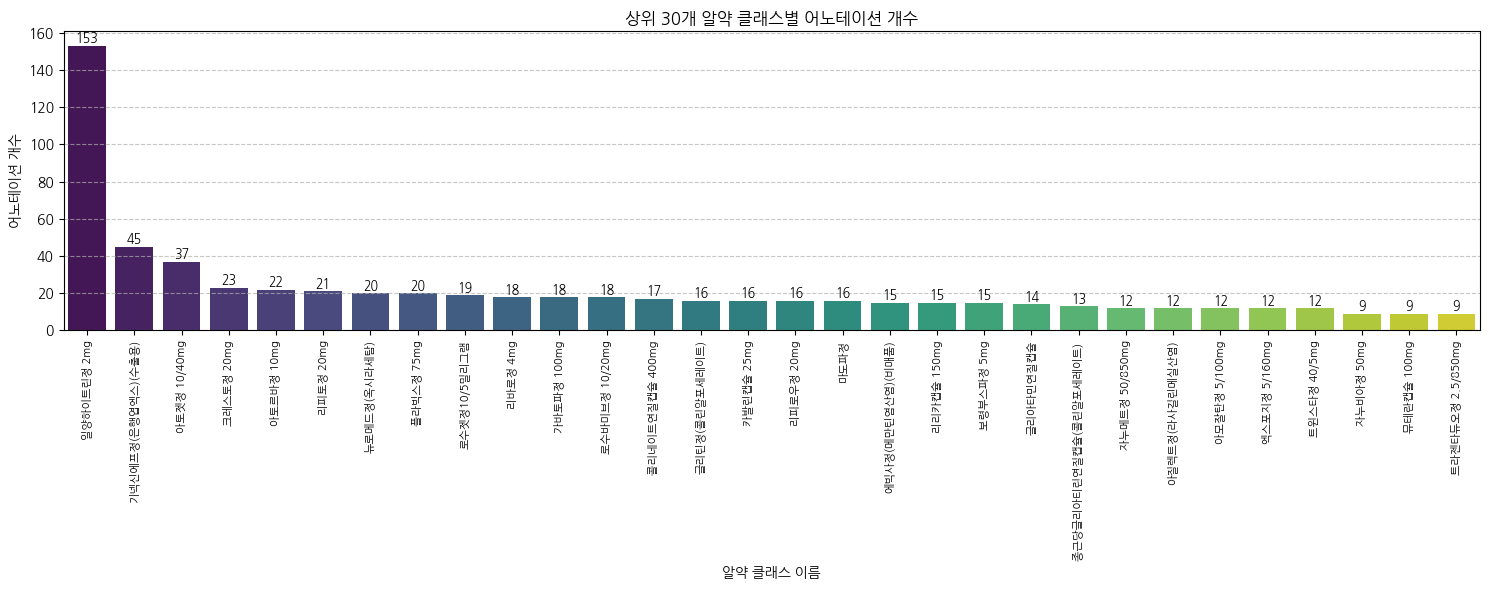


클래스별 어노테이션 개수 요약:
count     56.000000
mean      13.625000
std       20.823555
min        3.000000
25%        3.000000
50%        9.000000
75%       16.000000
max      153.000000
Name: count, dtype: float64
가장 적은 어노테이션 개수를 가진 클래스: 3개
가장 많은 어노테이션 개수를 가진 클래스: 153개


In [9]:
plt.figure(figsize=(15, 6))
class_counts = annotations_df['global_class_name'].value_counts()
top_n = min(len(class_counts), 30) # 상위 30개 클래스 또는 전체 클래스 수만큼 시각화

ax = sns.barplot(x=class_counts.head(top_n).index, y=class_counts.head(top_n).values, palette='viridis')
plt.title(f'상위 {top_n}개 알약 클래스별 어노테이션 개수')
plt.xlabel('알약 클래스 이름')
plt.ylabel('어노테이션 개수')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

print("\n클래스별 어노테이션 개수 요약:")
print(class_counts.describe())
print(f"가장 적은 어노테이션 개수를 가진 클래스: {class_counts.min()}개")
print(f"가장 많은 어노테이션 개수를 가진 클래스: {class_counts.max()}개")

## 6. 이미지 특성 분석

훈련 이미지 파일들의 해상도 및 기타 특성을 확인합니다.

### 6.1. 이미지 해상도 분포


이미지 해상도 요약 통계:
       width  height
count  232.0   232.0
mean   976.0  1280.0
std      0.0     0.0
min    976.0  1280.0
25%    976.0  1280.0
50%    976.0  1280.0
75%    976.0  1280.0
max    976.0  1280.0


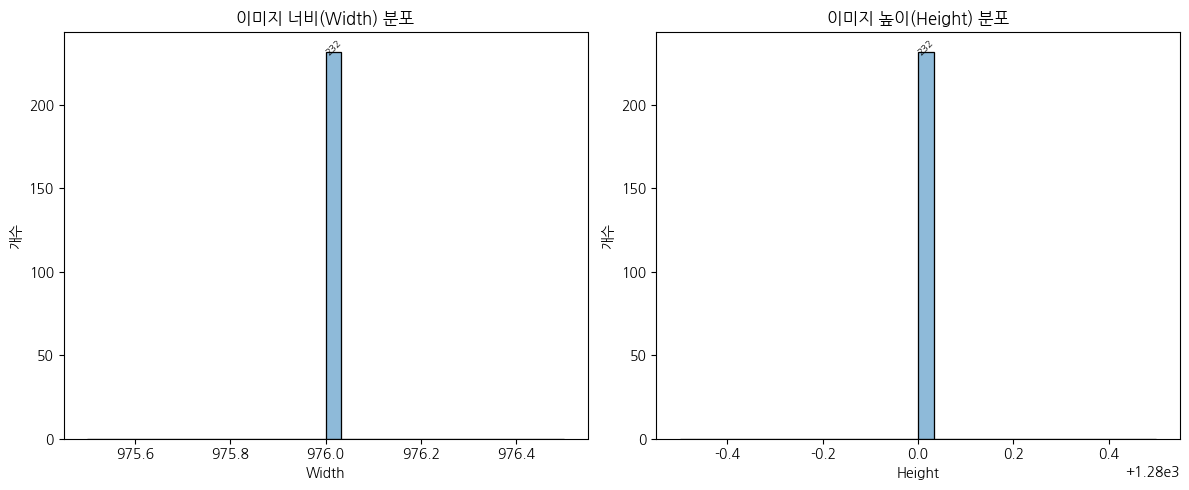

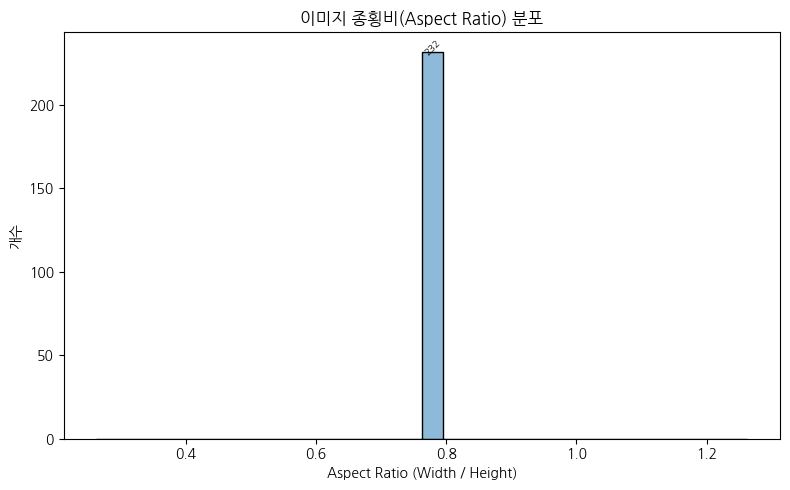

In [10]:
image_dims_df = images_df[['width', 'height']].copy()

print("\n이미지 해상도 요약 통계:")
print(image_dims_df.describe())

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(image_dims_df['width'], bins=30, kde=True, ax=ax1)
plt.title('이미지 너비(Width) 분포')
plt.xlabel('Width')
plt.ylabel('개수')

for p in ax1.patches:
    height = p.get_height()
    if height > 0: # 0보다 큰 경우에만 표시
        ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', fontsize=7, color='black', xytext=(0, 3),
                     textcoords='offset points', rotation=45)

ax2 = plt.subplot(1, 2, 2)
sns.histplot(image_dims_df['height'], bins=30, kde=True, ax=ax2)
plt.title('이미지 높이(Height) 분포')
plt.xlabel('Height')
plt.ylabel('개수')

for p in ax2.patches:
    height = p.get_height()
    if height > 0: # 0보다 큰 경우에만 표시
        ax2.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', fontsize=7, color='black', xytext=(0, 3),
                     textcoords='offset points', rotation=45)

plt.tight_layout()
plt.show()

# 이미지 종횡비 계산 (항상 이 부분에서 'aspect_ratio' 컬럼이 생성되어야 함)
image_dims_df['aspect_ratio'] = image_dims_df['width'] / image_dims_df['height']

# 이미지 종횡비 분포 플롯
plt.figure(figsize=(8, 5))
ax_ratio = sns.histplot(image_dims_df['aspect_ratio'], bins=30, kde=True)
plt.title('이미지 종횡비(Aspect Ratio) 분포')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('개수')

for p in ax_ratio.patches:
    height = p.get_height()
    if height > 0: # 0보다 큰 경우에만 표시
        ax_ratio.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='center', fontsize=7, color='black', xytext=(0, 3),
                          textcoords='offset points', rotation=45)

plt.tight_layout()
plt.show()

## 7. 어노테이션 특성 분석

알약의 개수, 바운딩 박스(bbox)의 크기 및 종횡비 등을 분석합니다.

### 7.1. 이미지당 알약 개수 분포

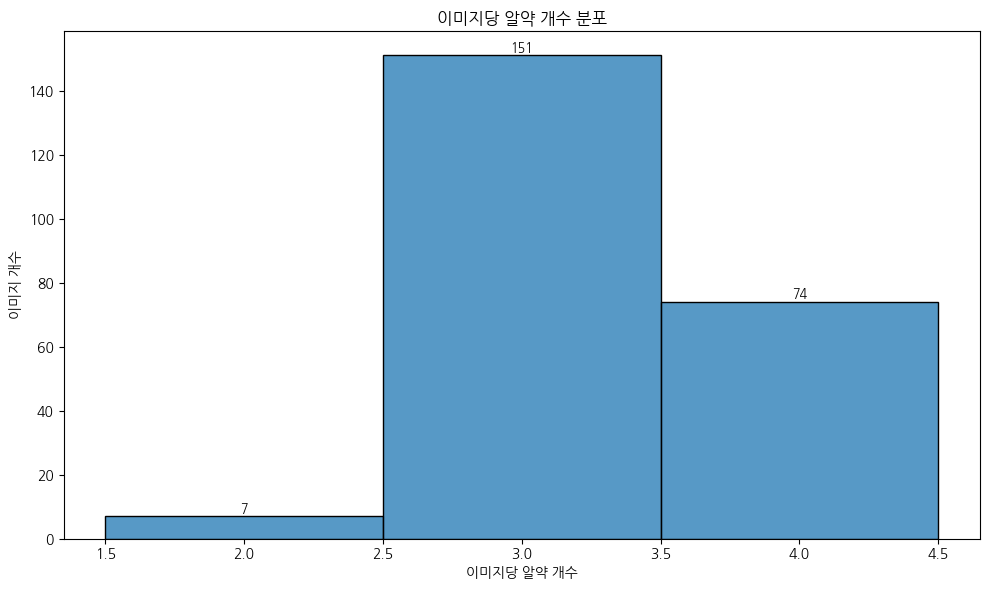


이미지당 알약 개수 요약:
count    232.000000
mean       3.288793
std        0.516611
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        4.000000
dtype: float64

4개 초과 알약이 있는 이미지 개수: 0개
이는 전체 이미지의 약 0.00% 에 해당합니다.


In [11]:
pills_per_image = annotations_df.groupby('image_id').size()

plt.figure(figsize=(10, 6))
ax = sns.histplot(pills_per_image, bins=range(int(pills_per_image.min()), int(pills_per_image.max()) + 2), kde=False, discrete=True)
plt.title('이미지당 알약 개수 분포')
plt.xlabel('이미지당 알약 개수')
plt.ylabel('이미지 개수')
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    if height > 0: # 0보다 큰 경우에만 표시
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

print("\n이미지당 알약 개수 요약:")
print(pills_per_image.describe())

num_images_gt_4_pills = (pills_per_image > 4).sum()
print(f"\n4개 초과 알약이 있는 이미지 개수: {num_images_gt_4_pills}개")
print(f"이는 전체 이미지의 약 {num_images_gt_4_pills / len(images_df) * 100:.2f}% 에 해당합니다.")

### 7.2. 바운딩 박스(bbox) 크기 및 종횡비 분포


바운딩 박스 크기 요약 통계:
            width      height           area  aspect_ratio
count  763.000000  763.000000     763.000000    763.000000
mean   250.007864  265.764089   70384.792923      0.991525
std     73.772225   95.652529   42608.636579      0.268859
min    125.000000  126.000000   23250.000000      0.396084
25%    189.500000  191.000000   36672.000000      0.828811
50%    230.000000  227.000000   53600.000000      1.000000
75%    285.000000  316.000000   93492.500000      1.040713
max    529.000000  664.000000  272435.000000      2.108374


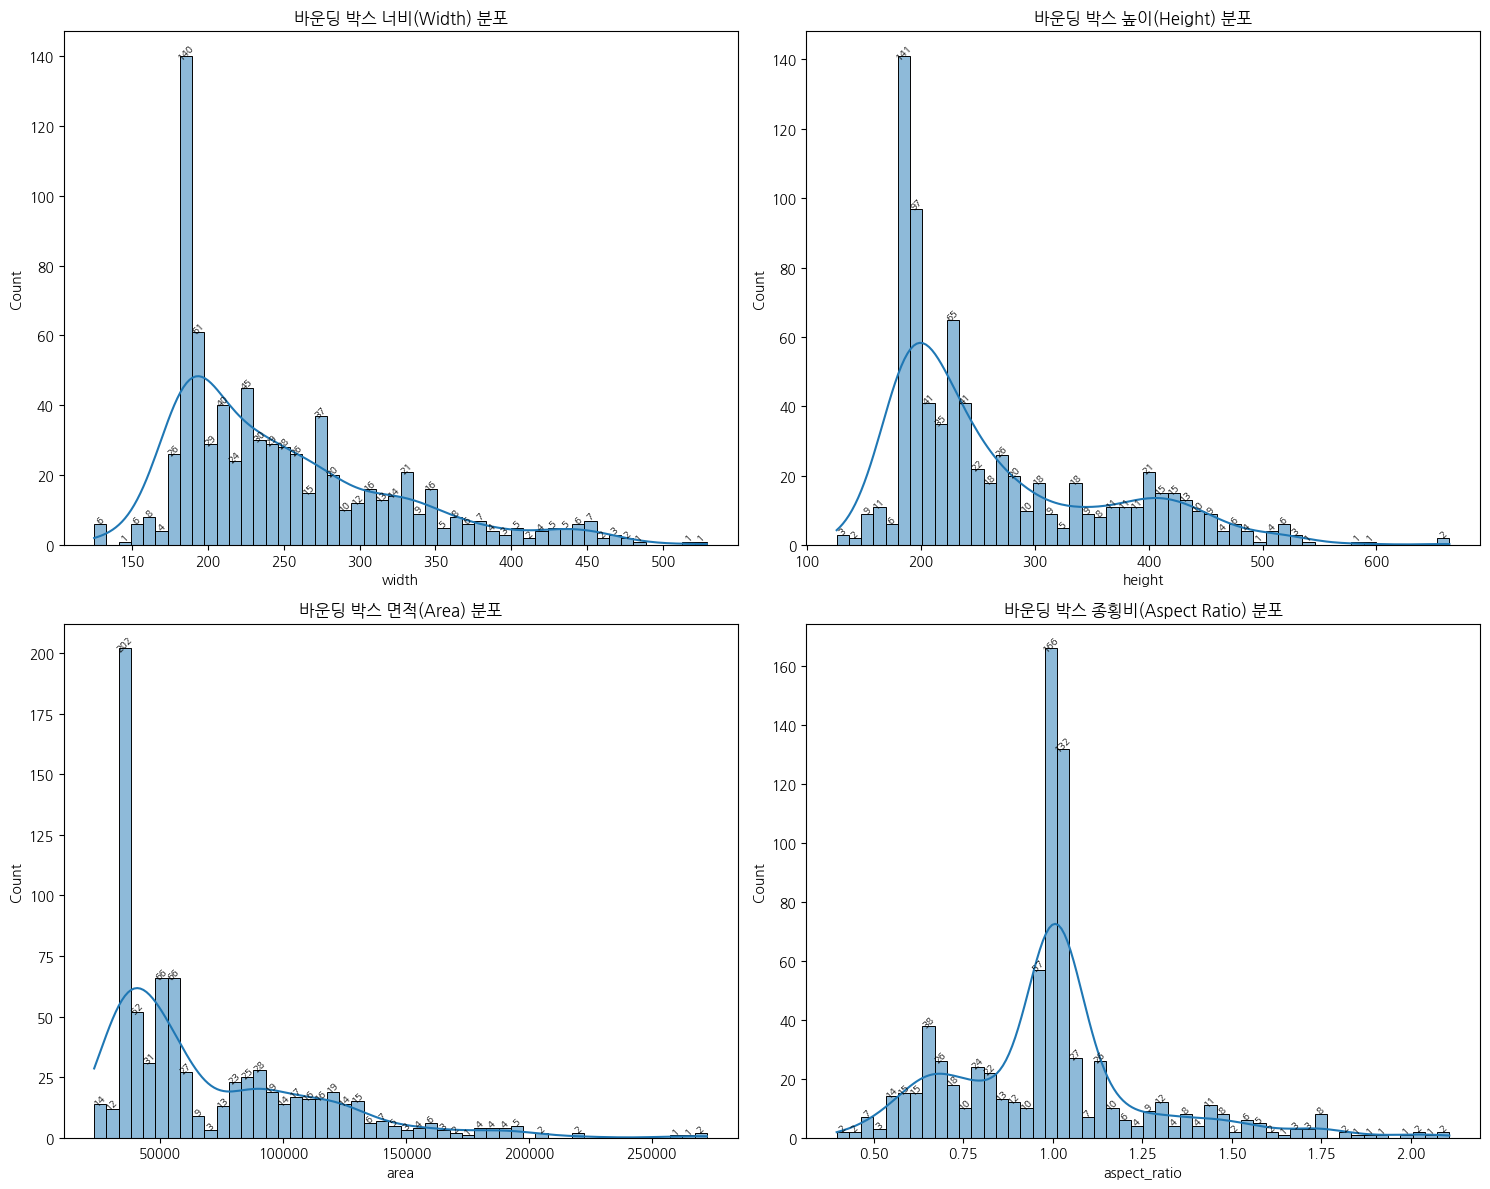


가장 작은 바운딩 박스 (상위 5개):
       x    y  width  height   area  aspect_ratio
42   657  287    155     150  23250      1.033333
323  662  333    157     150  23550      1.046667
43   177  880    158     155  24490      1.019355
322  171  821    159     155  24645      1.025806
321  140  787    160     157  25120      1.019108

가장 큰 바운딩 박스 (상위 5개):
       x    y  width  height    area  aspect_ratio
388   17  651    529     515  272435      1.027184
225   19  649    516     524  270384      0.984733
284   33  520    450     590  265500      0.762712
512   34  524    443     584  258712      0.758562
260  481  119    418     527  220286      0.793169


In [12]:
# bbox 정보 추출 (x, y, width, height)
bbox_df = pd.DataFrame(annotations_df['bbox'].tolist(), columns=['x', 'y', 'width', 'height'])
bbox_df['area'] = bbox_df['width'] * bbox_df['height']
bbox_df['aspect_ratio'] = bbox_df['width'] / bbox_df['height']

print("\n바운딩 박스 크기 요약 통계:")
print(bbox_df[['width', 'height', 'area', 'aspect_ratio']].describe())

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = sns.histplot(bbox_df['width'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('바운딩 박스 너비(Width) 분포')

for p in ax1.patches:
    height = p.get_height()
    if height > 0: ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=7, color='black', xytext=(0,3), textcoords='offset points', rotation=45)

ax2 = sns.histplot(bbox_df['height'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('바운딩 박스 높이(Height) 분포')

for p in ax2.patches:
    height = p.get_height()
    if height > 0: ax2.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=7, color='black', xytext=(0,3), textcoords='offset points', rotation=45)

ax3 = sns.histplot(bbox_df['area'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('바운딩 박스 면적(Area) 분포')

for p in ax3.patches:
    height = p.get_height()
    if height > 0: ax3.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=7, color='black', xytext=(0,3), textcoords='offset points', rotation=45)

ax4 = sns.histplot(bbox_df['aspect_ratio'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('바운딩 박스 종횡비(Aspect Ratio) 분포')

for p in ax4.patches:
    height = p.get_height()
    if height > 0: ax4.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=7, color='black', xytext=(0,3), textcoords='offset points', rotation=45)

plt.tight_layout()
plt.show()

# 이상치 바운딩 박스 확인
print("\n가장 작은 바운딩 박스 (상위 5개):")
print(bbox_df.nsmallest(5, 'area'))
print("\n가장 큰 바운딩 박스 (상위 5개):")
print(bbox_df.nlargest(5, 'area'))

## 8. 촬영 환경 및 알약 메타데이터 분석

이미지 메타데이터(약의 모양, 색상, 배경 등)를 분석하여 데이터 증강 전략을 수립하는 데 활용합니다.

### 8.1. 알약 모양(drug_shape), 색상(color_class1), 식별문자(print_front) 분포

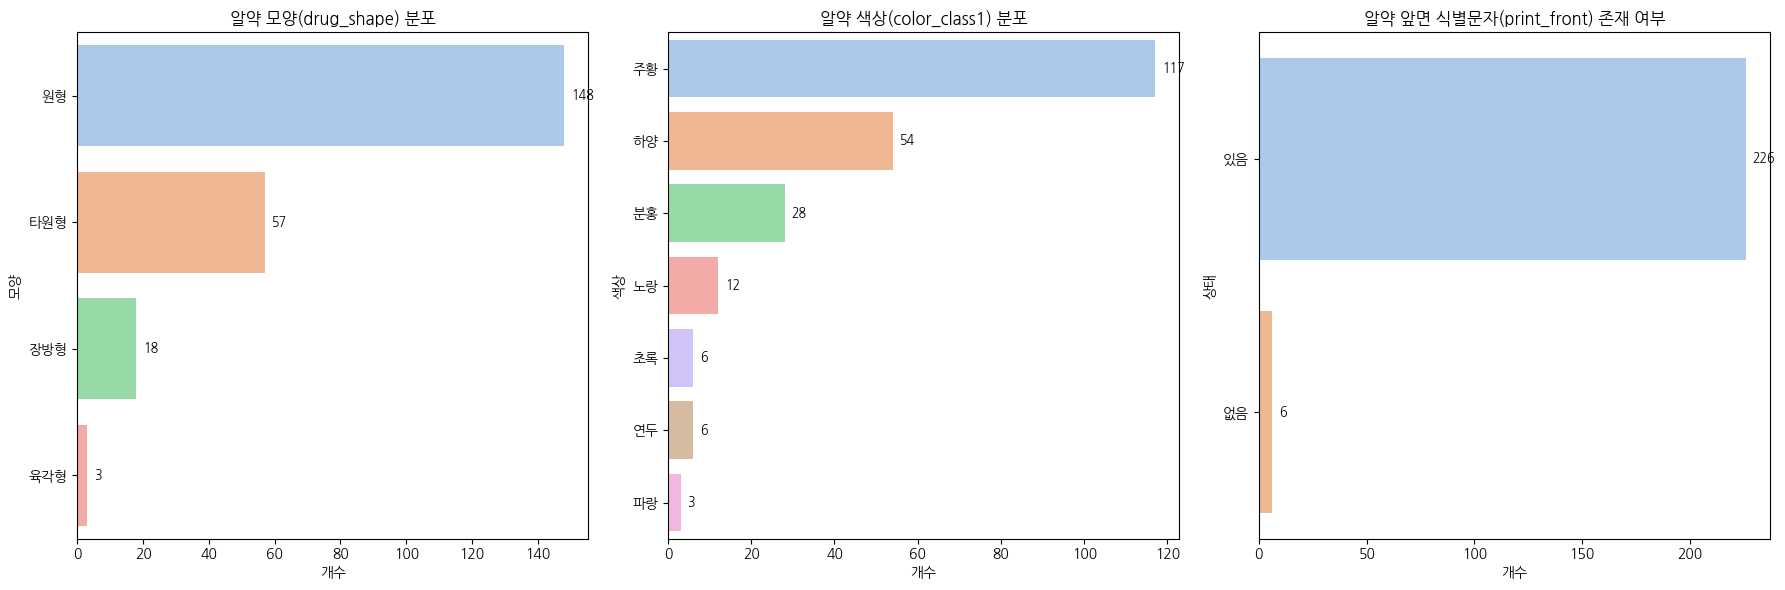

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 알약 모양 분포
ax1 = sns.countplot(y=images_df['drug_shape'], ax=axes[0], order=images_df['drug_shape'].value_counts().index, palette='pastel')
axes[0].set_title('알약 모양(drug_shape) 분포')
axes[0].set_xlabel('개수')
axes[0].set_ylabel('모양')

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                 textcoords='offset points')

# 알약 색상 분포 (color_class1)
ax2 = sns.countplot(y=images_df['color_class1'], ax=axes[1], order=images_df['color_class1'].value_counts().index, palette='pastel')
axes[1].set_title('알약 색상(color_class1) 분포')
axes[1].set_xlabel('개수')
axes[1].set_ylabel('색상')

for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                 textcoords='offset points')

# 알약 앞면 식별문자 존재 여부 (print_front)
images_df['print_front_status'] = images_df['print_front'].apply(lambda x: '있음' if pd.notna(x) and x not in ['', 'nan'] else '없음')
ax3 = sns.countplot(y=images_df['print_front_status'], ax=axes[2], palette='pastel')
axes[2].set_title('알약 앞면 식별문자(print_front) 존재 여부')
axes[2].set_xlabel('개수')
axes[2].set_ylabel('상태')

for p in ax3.patches:
    ax3.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                 textcoords='offset points')

plt.tight_layout()
plt.show()

### 8.2. 촬영 배경(back_color) 및 조명(light_color) 분포

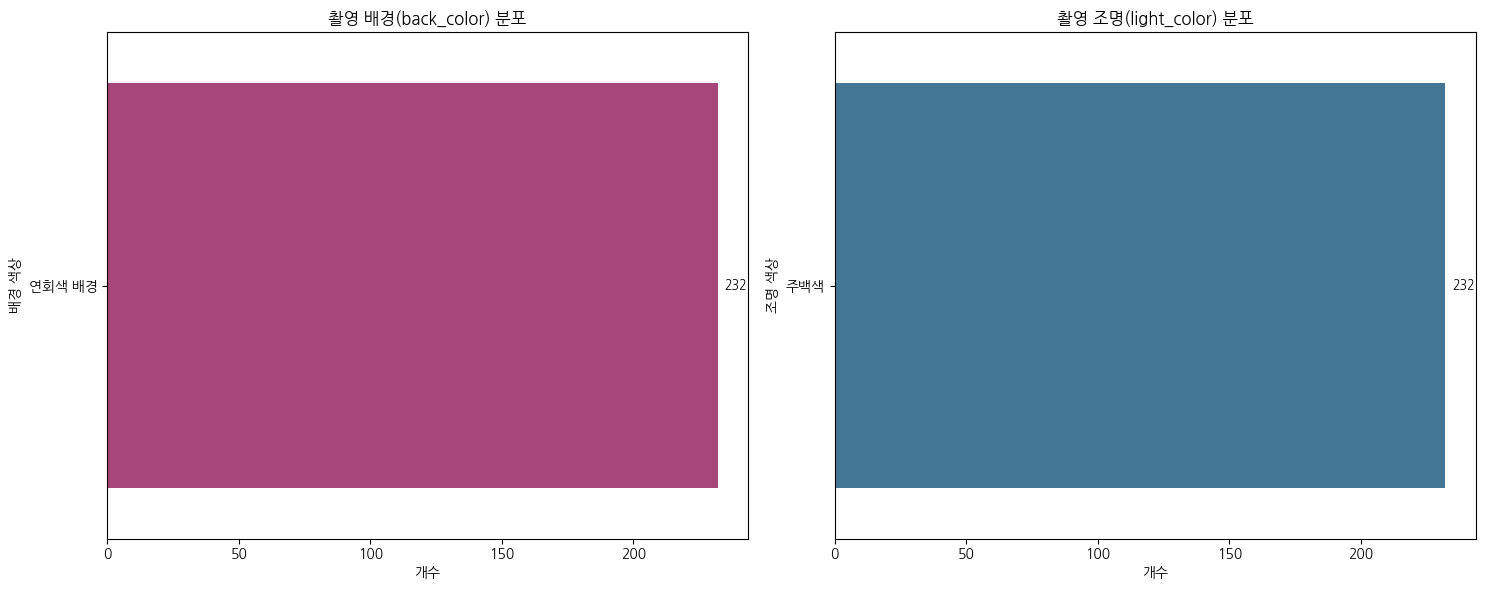

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 촬영 배경 분포
ax1 = sns.countplot(y=images_df['back_color'], ax=axes[0], order=images_df['back_color'].value_counts().index, palette='magma')
axes[0].set_title('촬영 배경(back_color) 분포')
axes[0].set_xlabel('개수')
axes[0].set_ylabel('배경 색상')

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                 textcoords='offset points')


# 촬영 조명 분포
ax2 = sns.countplot(y=images_df['light_color'], ax=axes[1], order=images_df['light_color'].value_counts().index, palette='mako')
axes[1].set_title('촬영 조명(light_color) 분포')
axes[1].set_xlabel('개수')
axes[1].set_ylabel('조명 색상')

for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=9, color='black', xytext=(5, 0),
                 textcoords='offset points')

plt.tight_layout()
plt.show()

## 9. 데이터 시각화 (샘플 이미지와 어노테이션)

몇몇 랜덤 샘플 이미지를 선택하여 실제 바운딩 박스와 클래스명이 어떻게 주석되어 있는지 시각적으로 확인합니다.

랜덤 샘플 3개 이미지와 어노테이션을 시각화합니다.


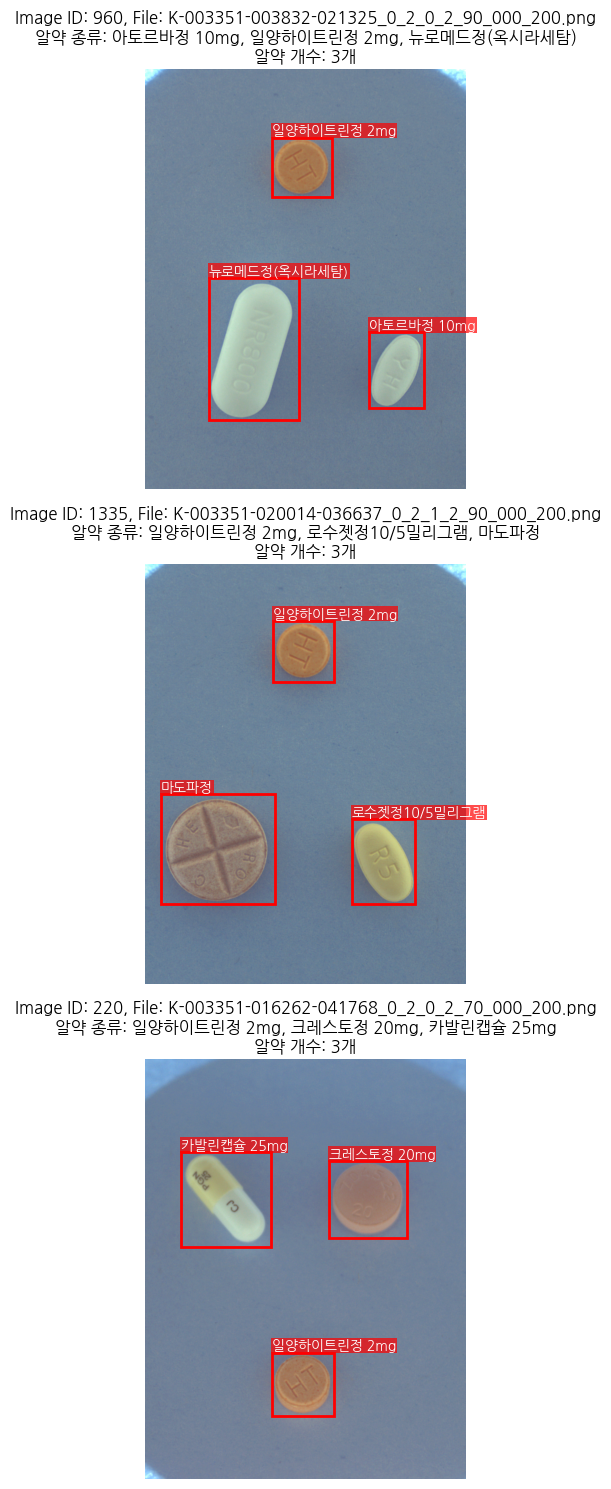

In [15]:
# 이미지-어노테이션 쌍이 있는 이미지 ID 목록 추출
image_ids_with_annotations = annotations_df['image_id'].unique()

plt.figure(figsize=(18, 5 * 3)) # 그림 크기 조정 (3개 샘플 기준)
num_samples_to_display = 3 # 시각화할 이미지 샘플 개수

# 출력 메시지 (ipywidgetsKernel 에러 방지)
print(f"랜덤 샘플 {num_samples_to_display}개 이미지와 어노테이션을 시각화합니다.")

for i in range(num_samples_to_display):
    # 랜덤으로 이미지 ID 선택
    sample_image_id = random.choice(image_ids_with_annotations)
    sample_img_meta = images_df[images_df['id'] == sample_image_id].iloc[0]
    sample_annotations = annotations_df[annotations_df['image_id'] == sample_image_id]

    # 이미지 로드
    img_path = os.path.join(TRAIN_IMG_DIR, sample_img_meta['file_name'])
    try:
        image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"경고: 이미지 파일을 찾을 수 없습니다: {img_path}. 건너뜁니다.")
        continue
    except Exception as e:
        print(f"경고: 이미지 {img_path} 로드 중 예외 발생: {e}. 건너뜁니다.")
        continue
    
    ax = plt.subplot(num_samples_to_display, 1, i + 1)
    ax.imshow(image)
    
    # 바운딩 박스 그리기
    for idx, row in sample_annotations.iterrows():
        x, y, w, h = row['bbox']
        class_name = row['global_class_name']
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # 클래스명 텍스트
        ax.text(x, y - 10, class_name, color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=0.5))
    
    ax.set_title(f"Image ID: {sample_image_id}, File: {sample_img_meta['file_name']}\n"
                 f"알약 종류: {', '.join(sample_annotations['global_class_name'].unique())}\n"
                 f"알약 개수: {len(sample_annotations)}개", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 10. EDA 요약

- 데이터 규모: 총 232개의 유효 훈련 이미지와 763개의 알약 객체 어노테이션이 존재하며, 테스트 이미지는 843개입니다. (초기 이미지 수보다 학습 가능한 이미지 수가 현저히 줄었음을 인지해야 합니다.)
- 클래스 다양성: 총 56개의 고유 알약 클래스가 확인되었으며, 이는 테스트셋 클래스(40개)보다 16개 많습니다. 훈련셋에 없는 클래스가 테스트셋에 포함될 수 있으며, 훈련셋에 있는 일부 클래스가 테스트셋에 없을 수 있어 클래스 불일치 문제에 대한 전략이 필요합니다.
- 클래스 불균형: 클래스별 어노테이션 개수는 최소 4개에서 최대 123개로, 심각한 클래스 불균형이 존재합니다.
- 이미지 해상도: 모든 이미지는 980x1280 픽셀로 고정된 세로형 해상도를 가집니다.
- 알약 개수: 이미지당 알약 개수는 평균 3.28개 (763개 어노테이션 / 232개 이미지)입니다.
- 바운딩 박스 크기: 알약들의 바운딩 박스는 크기 편차가 크고(면적 3000~120000px^2), 종횡비는 0.5~2.0 범위로 다양하지만 대부분 정사각형에 가깝습니다(평균 1.16).
- 메타데이터 활용: 알약의 drug_shape, color_class1, print_front는 중요한 시각적 특징입니다.
- 촬영 환경: 배경은 연회색 배경, 조명은 주백색이 압도적으로 많아 배경과 조명에 대한 모델의 과적합 위험이 높습니다.
- 테스트셋 파일명: test_images의 파일명이 97.png와 같이 단순히 숫자로 되어 있어, 실제 제품명으로의 매핑 정보가 별도로 필요해 보입니다.

## 11. EDA 기반 전처리 전략 제안

- Resize 크기 제안
    - 원본 해상도가 전부 976×1280으로 동일하며 이상치가 없어, 1차 단계에서는 비율 유지 축소 후 모델 입력에 맞게 padding/resize 하는 방식을 적용한다.  
    (예시) 976×1280 → 640×(640·1280/976 ≈ 840) 후 letterbox로 640×640 맞추기

- Normalization 제안
    - RGB 채널을 로 스케일링 후 ImageNet 표준(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 또는 자체 데이터셋에서 계산한 mean/std를 사용한다.

    - 배경·조명이 거의 단일 조건이므로, 정규화 자체는 모델 안정화 목적에 집중한다.

- Augmentation 전략
    - 밝기/대비 조절: 조명과 배경이 너무 균일하므로, 밝기·대비를 ±20~30% 범위에서 랜덤 조절해 실제 사용자 환경(잡광, 어두운 방 등)에 대한 일반화를 높인다.

    - rotation: 약 방향이 앞면·뒷면 두 가지 정도로 제한되어 있지만, 실제 촬영에서는 회전이 더 다양할 수 있으므로 ±10~15도 범위의 작은 회전을 적용한다.
    - color jitter: color_class1/2가 다양한 편이지만 배경·조명은 단일이므로, 색조·채도는 작은 폭(±0.1~0.2 수준)에서만 조절해 약 색상의 클래스 구분 정보를 해치지 않도록 한다.

- 기타
    - 이미지당 평균 annotation 수가 약 2.7개로, 모든 이미지가 4개 알약을 가지지 않으므로 “항상 4개”를 강제하는 후처리는 하지 않는다.

    - 매우 작은 bbox나 극단적 area는 없으므로, bbox 기반 필터링은 필요 없고, 학습 시 IoU threshold·anchor 설정만 조정한다.

- 클래스 불균형 해결 전략
    - 상위 클래스가 전체의 약 24%를 차지하고 최하위 클래스는 0.3% 수준이라, 1:80 정도의 심한 불균형이 존재한다.

**데이터 정합성 이슈**
- 폴더에는 존재하지만 JSON 어노테이션에 없는 이미지가 419장, JSON에는 언급되어 있지만 실제 폴더에 없는 이미지가 137장 존재해, 이미지–어노테이션 매칭 관점에서 결함이 있는 데이터셋임을 확인했다.

- 정합성 대응 방안
    - 1안: 보수적인 필터링
        - Train에 사용할 데이터는 “이미지도 존재하고, JSON에도 등장하며, 해당 이미지에 최소 1개 이상의 어노테이션이 붙어 있는 경우”만 사용한다.

        - 장점: 학습에 사용하는 샘플은 모두 신뢰 가능한 정답을 가진다는 보장이 있어 디버깅이 쉽고, 모델이 잘못된 GT에 노출될 가능성을 줄일 수 있다.
        - 단점: 사용 가능한 학습 이미지 수가 줄어들기 때문에, 이미 적은 클래스(소수 클래스)의 데이터가 더 줄어들 수 있다.
        - 보완방법: 강한 데이터 증강으로 정합된 샘플을 여러 변형본으로 늘리고, 소수 클래스가 포함된 이미지에 증강을 집중해서 실질 샘플 수를 보완한다.

    - 2안: 비정합 샘플 제한적 활용
         - 폴더에는 있지만 JSON에 없는 이미지는 “라벨 없는 추가 데이터”로 간주해, augmentation/사전학습용(예: self-supervised pretraining)으로만 활용한다.

         - JSON에는 있지만 실제 폴더에 없는 이미지는 학습 파이프라인에서 완전히 제외한다.(로딩 시 에러 소지)
         - 장점: 정상 라벨 데이터는 1안과 같이 깨끗하게 유지하면서, 추가 실험에 한해 원본 이미지를 더 활용할 여지를 남긴다.
         - 단점: 구현 복잡도가 조금 올라가며, 기본 학습 코드와 별도의 경로 관리가 필요하다.
         - 보완방법: 라벨 없는 이미지는 먼저 자기지도학습이나 pseudo-labeling에 사용하고, confidence 기준으로 고품질 샘플만 선별하여 추가 학습에 사용하는 식으로 노이즈를 최소화한다.

## 12. 데이터 파이프라인 초안

- transform 구성
    - Train  
        Resize → Letterbox(예: 640×640) → RandomHorizontalFlip → RandomBrightnessContrast / ColorJitter → ToTensor → Normalize(mean, std).

    - Val/Test
        Resize/Letterbox만 적용 후 ToTensor → Normalize, augmentation은 적용하지 않는다.

- Dataset/Dataloader 구성 방식
    - COCO 스타일의 images_df, annotations_df를 기반으로, image_id를 key로 이미지 경로와 해당 이미지의 bbox·category 리스트를 묶는 커스텀 Dataset 클래스를 구현한다.

    - Dataloader에서는 collate_fn을 정의해 이미지 하나에 여러 bbox가 포함된 형태(batch 단위 variable-length target)를 그대로 유지하고, shuffle·num_workers 등을 조절해 I/O 병목을 줄인다.

- train/val split 비율
    - 전체 train 이미지를 기준으로 8:2 비율로 랜덤 분할하되, 클래스 불균형을 고려해 stratified split(클래스 분포를 비슷하게 유지)하는 것이 바람직하다.